In [19]:
import numpy as np
import matplotlib.pyplot as plt

## Monte Carlo Integration
Estimate multi-dimensional integral (over unit hypercube) by randomly sampling $N$ abscissas: 
$$ I = \int{d^dx \; f(x)} \approx  E = \frac{1}{N} \sum_{n=1}^{N}{f(x_n)} , $$
with equality for $N \rightarrow \infty $ (if the random process used to sample $x_n$ has a constant natural density). Define variance of a function $f$ as
$$ \sigma^2(f) = \int { d^dx \; (f(x)-I)^2 } .$$
Using this, the variance of the Monte Carlo estimate is
$$ 
\int { dx_1...dx_N \left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 }
= \int { dx_1...dx_N \frac{1}{N^2} \sum_{n=1}^N \sum_{m=1}^N (f(x_n)- I)(f(x_m)- I) } 
= \int {dx_1...dx_N \frac{1}{N^2} \sum_n{(f(x_n)-I)^2}}
= \frac{\sigma(f)^2}{N},
$$
since for $n \neq m$ the integrals separate and clearly $\int{dx\;(f(x)-I)} = 0$. 

The variance can be estimated using the unbiased sample variance
$$ S^2 = \frac{1}{N-1} \sum_{n=1}^N{(f(x_n)-E)^2} = \frac{1}{N-1}\sum_n{f(x_n)^2 } - \frac{N}{N-1}E^2$$

In [20]:
class MonteCarloPlain(object):
    
    def __init__(self, dim=1, name="MC Plain"):
        self.dim = dim
        self.method_name = name
        
    def __call__(self, f, N):
        """ Compute Monte Carlo estimate of N-dimensional integral of f over the unit hypercube.

        Returns:
            tuple (integral_estimate, error_estimate),
            where the error_estimate is based on the unbiased sample variance of the function,
            computed on the same sample as the integral.
        """
        int_est = 0  # estimated integral of f
        var_est = 0  # estimated variance of f
        for i in range(N):
            x = np.random.rand(self.dim)
            value = f(x)        # f must return a 1D value
            int_est += value/N  # int_est is just the average of f over N values (multiplied by volume = 1)
            var_est += value**2/(N-1)
        var_est -= N/(N-1) * int_est**2
        return int_est, np.sqrt(var_est/N)    

In [21]:
# this will be useful later on to compare integration results from several MC methods
def compare_integration(f, true_value, methods,  Nmin=2, Nmax=200, Nstep=5, dim=1):
    """ Plot the exact value vs the estimates and errors of each method for various sample sizes. """
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    estimate = np.empty(samples_count)  # integral for each sample size
    error = np.empty(samples_count)     # error estimate for each sample size

    for method in methods:
        for i in range(samples_count):
            estimate[i], error[i] = method(f, Ns[i])
        print("{}\taverage (deviation * sqrt(N)): {}, average (error * sqrt(N)): {}".format(
                method.method_name, np.average(abs(estimate - true_value)*np.sqrt(Ns)), np.average(np.sqrt(Ns)*error)))
        
        # plot estimated integral with one-sigma error intervals
        plt.errorbar(Ns, estimate, yerr=error, fmt=".-", label=method.method_name)
    # plot true value
    plt.plot([Ns[0], Ns[-1]], [true_value, true_value], "-", label="exact value")
    # configure plot
    plt.grid()
    plt.legend(loc="best")

MC Plain	average (deviation * sqrt(N)): 0.3945072437738847, average (error * sqrt(N)): 0.4755310526520263


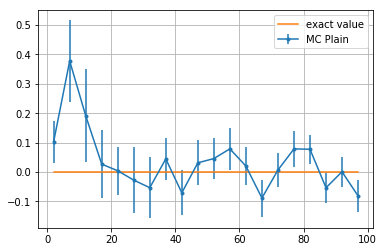

In [22]:
# simple example: sin(2 pi x)*sin(2 pi y). Integral over [0,1]^2 should give 0
compare_integration(lambda x: np.sin(2*np.pi*x[0])*np.sin(2*np.pi*x[1]), 0, Nmin=2, Nmax=100, methods=[MonteCarloPlain(2)])

MC Plain	average (deviation * sqrt(N)): 1.8652453233897404, average (error * sqrt(N)): 1.7761475275914407


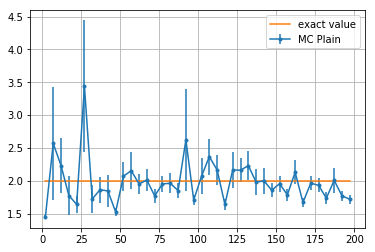

In [23]:
# f(x) = 1/sqrt(x) is integrable and MC converges to true value, but error estimate relied on square-integrability.
# the variance of f does not converge, which implies the estimate of this cannot yield a good error estimate
compare_integration(lambda x: 1/np.sqrt(x), 2, Nmax=200, Nstep=5, methods=[MonteCarloPlain()])

## Variance Reducing Techniques
The error in the MC estimate scales like $1/\sqrt{N}$, which constitutes a slow convergence. Improving this value is desirable.
### stratified sampling
Split $M=[0,1]^d$ into $k$ regions $M_j$, in each region perform MC with $N_j$ points. We obtain the estimate
$$ E = \sum_{j=1}^k {\frac{\text{vol}(M_j)}{N_j}} \sum_{n=1}^{N_j} {f(x_{jn})}, $$
and the variance of the MC estimate becomes
$$ 
\sum_{j=1}^k {\frac{\text{vol}(M_j)^2}{N_j} \left.\sigma^2(f)\right|_{M_j} }, \; \text{with} \;  
\left.\sigma^2(f)\right|_{M_j} = \frac{1}{\text{vol}(M_j)}\int_{M_j} {dx \left( f(x) - \frac{1}{\text{vol}(M_j)}\int_{M_j}{dx f(x)}  \right)^2}.
$$
Whether this method reduces or increases the variance depends on the choice of subspaces and respective point counts. It is obvious from the expression that to reduce the error/variance, regions with larger variance should have assigned larger $N_j$. Generally, for minimal variance the number of points must be chosen proportional to $\left.\sigma(f)\right|_{M_j}$.

In [24]:
# For the strafield monte carlo varient we first need a way to encode the volumes, 
# iterate over them and sample each one appropriately.
# The simplest division is simple cubic
class CubeVolumes(object):
    def __init__(self, divisions:int, Ns={}, otherNs=1, dim=1):
        """ Initialize a division of a <dim>-dimensional hypercube into <divisions> cubes along each dimension.
        
        divisions: number of subregions along one axis. For dim=3, there will be divisions^3 subregions.
        Ns: dictionary for setting the number of samples for specific subregions (cubes).
            Example: Ns={(1,0,0): 4} to assign 4 samples to the cube 1 away from the origion along the first dimension.
        otherNs: number of samples to be assigned to all remaining cubes.
        dim: dimensionality of the cube.
        """
        self.Ns = Ns
        self.divisions = divisions
        self.dim = dim
        # volume of all regions is constant
        self.vol = 1/divisions**dim
        self.otherNs = otherNs
        self.totalN = sum(Ns.values()) + (divisions**dim - len(Ns)) * otherNs
    
    def iterate(self, multiple=1):
        """ multiply N in each division by multiple. Total number of samples is self.totalN()*multiple. 
        
        yields tuple (N, sample, vol), 
        where N is the number of samples in the region, sample is a function that samples the region uniformly.
        """
        for index in np.ndindex(*([self.divisions]*self.dim)):
            def sample_region():
                return np.array(index) / self.divisions + np.random.rand(self.dim) / self.divisions
            yield multiple * (self.Ns[index] if index in self.Ns else self.otherNs), sample_region, self.vol

# iterate and sample a 1D volume, divided into 5 regions, with doulbe weight on the fourth region (index (3,))
# volumes = CubeVolumes(5, Ns={(3,): 2}, otherNs=1)
volumes = CubeVolumes(2, otherNs=2, Ns={(0,):2})
for N, sample, vol in volumes.iterate(2):
    print(N, vol, [(lambda x: 1+(x<.5)*np.sin(np.pi*x))(sample()) for i in range(N)])

4 0.5 [array([1.99999746]), array([1.3935948]), array([1.22289561]), array([1.26287323])]
4 0.5 [array([1.]), array([1.]), array([1.]), array([1.])]


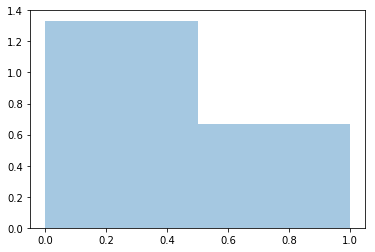

In [25]:
# visualization of 1d volumes
def plot_1d_volume(volumes, label="sampling weights"):
    assert volumes.dim == 1, "Can only plot volumes in 1 dimension."
    x = [volumes.vol*i for i in range(volumes.divisions)]
    height = [N/volumes.totalN/volumes.vol for N,_,_ in volumes.iterate()] # bar height corresponds to pdf
    rects1 = plt.bar(x, height, volumes.vol, align='edge', alpha=.4, label=label)
plot_1d_volume(CubeVolumes(2, otherNs=2, Ns={(1,): 1}))

In [26]:
class MonteCarloStratified(object):
    """ Compute Monte Carlo estimate of N-dimensional integral of f over the unit hypercube using strafield sampling.
    
    Note: N must be an integer multiple of volumes.totalN !

    Returns:
        tuple (integral_estimate, error_estimate)
    """
    def __init__(self, volumes=CubeVolumes(1), name="MC Stratified"):
        self.method_name = name
        self.dim = volumes.dim
        self.volumes = volumes
        
    def __call__(self, f, N):
        multiple = N // self.volumes.totalN 
        assert multiple > 0, "the strafield method requires the sample size N to be a multiple of volumes.totalN."
        int_est = 0  # estimated integral of f (i.e. sample average over unit cube)
        var_est = 0  # estimated variance of f
        for Nj, sample, vol in self.volumes.iterate(multiple):
            f_average = 0   # average of f over N samples in subregion
            f2_average = 0  # average of f^2 over N samples
            for i in range(Nj):
                x = sample()
                value = f(x) # f must return a 1D value
                f_average += value/Nj
                f2_average += value**2/Nj
            var_est += vol**2/Nj * (f2_average - f_average**2)
            int_est += vol * f_average
        return int_est, np.sqrt(var_est)

MC Plain	average (deviation * sqrt(N)): 0.5918608815341392, average (error * sqrt(N)): 0.7068568457180604
MC Stratified	average (deviation * sqrt(N)): 0.3081821289185076, average (error * sqrt(N)): 0.35634688534477915


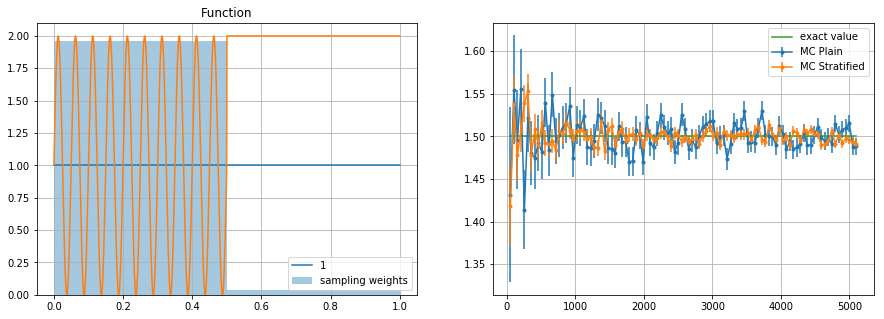

In [27]:
volumes = CubeVolumes(2, otherNs=1, Ns={(0,):50})
half_sin = lambda x: (x<.5)*(1+np.sin(4*10*np.pi*x)) + (x>.5)*2
half_sin_integral = 1.5

# plot the function
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
plot_1d_volume(volumes)
x = np.linspace(0,1,1000)
plt.plot(x, [1 for i in x], label="1")
plt.plot(x,half_sin(x))
plt.grid()
plt.legend()

# compare 
plt.subplot(122)
compare_integration(half_sin, half_sin_integral, Nmin=volumes.totalN, Nmax=volumes.totalN*100, Nstep=volumes.totalN, 
                    methods=[MonteCarloPlain(), MonteCarloStratified(volumes)])

plt.show()

In [28]:
# another nice plotting routine to compare predicted and actual errors of different methods/parameter choices
# for smoothing, average over given number of iterations
def compare_errors(f, true_value, iterations=1, Nmin=2, Nmax=100, Nstep=1, methods=[]):
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    errors = np.zeros(samples_count)
    ms = np.zeros(samples_count)
    for m in range(len(methods)):
        for i in range(samples_count):
            errors[i] = 0
            ms[i] = 0
            for j in range(iterations):
                val, err = methods[m](f, Ns[i])
                errors[i] += err/iterations
                ms[i] += (val-true_value)**2/iterations
                
        # plot average error
        plt.title("Errors, values scaled by $\\sqrt{N}$")
        plt.xlabel("N")
        plt.plot(Ns, errors*np.sqrt(Ns), ".-", label="%s predicted"%methods[m].method_name, color="C%d"%m)
        plt.plot(Ns, np.sqrt(ms)*np.sqrt(Ns), "--", label="%s rms deviation"%methods[m].method_name, color="C%d"%m)
        # configure plot
        plt.grid()
        plt.legend(loc="best")

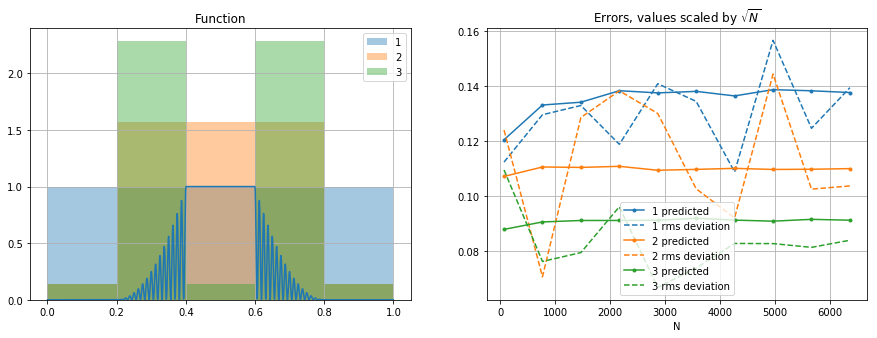

In [29]:
# on to a more compliated function to see how best to choose weights
tf_a = 16
tf_b = 1/.2**2
def osc(x):
    return x**2*np.cos(tf_a*np.pi*x/.2)**2*tf_b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
test_function_true_value = 2*.0333531 + .2

# plot function and volume choices for stratified sampling
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

vol1 = CubeVolumes(5, otherNs=14)
vol2 = CubeVolumes(5, otherNs=2, Ns={(1,):22, (3,):22, (2,):22})
vol3 = CubeVolumes(5, otherNs=2, Ns={(1,):32, (3,):32})
plot_1d_volume(vol1, "1")
plot_1d_volume(vol2, "2")
plot_1d_volume(vol3, "3")
plt.legend()

plt.subplot(122)

compare_errors(test_function, test_function_true_value, iterations=20, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
                    methods=[MonteCarloStratified(vol1, "1"), MonteCarloStratified(vol2, "2"), MonteCarloStratified(vol3, "3")])
plt.show()

**Observation**: It is most important to increase sampling in regions where f varies quickly.

(Note: stratified sampling is substantially different from importance sampling, which is why for stratified sampling regions of large variance of f should have bigger weights, whereas for importance sampling the pdf should be as close to f as possible.
In stratified sampling each region is considered individually and therefore when f is large but constant small samples will be acceptable. If $p(x)$ in importance sampling is small in these regions, these large values of f would be underrepresented and (as they yield large values of $f(x)/p(x)$) increase the variance of the MC estimate.)

### importance sampling
Consider a change of variables
$$ \int {dx \; f(x)} = \int {\frac{f(x)}{p(x)} dx} = \int {\frac{f(x)}{p(x)} dP(x)} $$
with $$ p(x) = \frac{\partial^d}{\partial x_1 ... \partial x_d} P(x) .$$

Interpret $p(x)$ as a probability density with $p(x) \geq 0$ and normalized: $\int{dx\;p(x)} = 1$. If the $x_n$ are sampled from the corresponding distribution $P(x)$, we have
$$ E = \frac{1}{N} \sum_{n=1}^{N}{\frac{f(x_n)}{p(x_n)}}.$$
The variance of the MC estimate is (analogously to the first calculation)
$$ 
\int { dx_1...dx_N \; p(x_1)...p(x_N)\left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 } 
= \frac{1}{N} \int {dx \; p(x) \left( \frac{f(x)}{p(x)} - I \right)^2 } = \frac{\sigma^2(f/p)}{N} \;,
$$
which may in turn be estimated by the sample variance, using E instead of I:
$$ 
\sigma^2\left(\frac{f}{p}\right) \approx S^2\left(\frac{f}{p}\right) 
= \frac{1}{N} \sum_{n=1}^N {\left(\frac{f(x_n)}{p(x_n)}\right)^2} - E^2 .
$$

Using $p$ which are (close to) zero where $f$ is not zero is dangerous as the variance diverges while the sample variance does not (appropriate regions are less likely to be sampled for small $p$).

MC Plain	average (deviation * sqrt(N)): 0.3543040497528767, average (error * sqrt(N)): 0.35357338059937893
MC Importance	average (deviation * sqrt(N)): 0.29750492637198733, average (error * sqrt(N)): 0.3538307379744436


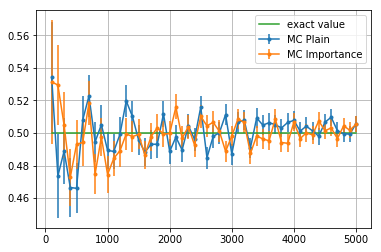

In [30]:
class MonteCarloImportance(object):
    """ sampling_fn returns random number according to the desired distribution. 
    
    By default, uniform probability distribution is used. pdf is weight function given the sampling distribution.
    """
    def __init__(self, dim=1, sampling_fn=None, pdf=lambda x:1, name="MC Importance"):
        self.method_name = name
        if sampling_fn is None:
            sampling_fn = np.random.rand if dim==1 else lambda: np.random.rand(dim)
        self.sampling_fn = sampling_fn
        self.pdf = pdf
        self.dim = dim
    
    def __call__(self, f, N):
        int_est = 0
        var_est = 0  # variance of (f/pdf)
        for i in range(N):
            x = self.sampling_fn()
            int_est += f(x)/self.pdf(x)/N
            var_est += np.power(f(x)/self.pdf(x),2)/N
        var_est -= int_est**2
        return int_est, np.sqrt(var_est/N)

f = lambda x: np.sin(x*2*np.pi)**2
# with the default values (uniform distribution) monte carlo importance and plain monte carlo are exactly equivalent 
compare_integration(f, 1/2, Nmin=100, Nmax=5000, Nstep=100, 
                    methods=[MonteCarloPlain(), MonteCarloImportance()])

## Generating Samples from a Given Distribution
### Acceptance-Rejection method
We want to sample according to a pdf $p(x)$. We know another (similar) pdf $h(x)$ s.t. $p(x) \leq Ch(x)$ for some $C \geq 0$.
Then use the following algorithm:
1. sample $x$ according to $h$
2. generate random number $u \in [0,1]$ and accept $x$ if $p(x) \geq uCh(x)$, else reject and start over

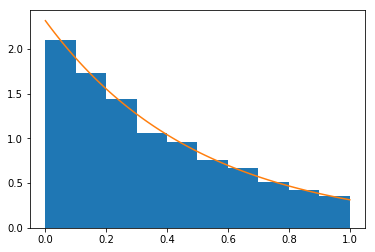

In [31]:
class AcceptionRejection(object):
    # for use in monte carlo it will be useful to have a parameter-less sample function, therefore use a callable object
    def __init__(self, p, C, h=lambda x: 1, h_sampling=np.random.rand):
        self.p = p
        self.C = C
        self.h = h
        self.sample = h_sampling
    def __call__(self):
        while True:
            x = self.sample()
            if np.random.rand() * self.C * self.h(x) <= self.p(x):
                return x

a = 2
p = lambda x: a/(1-np.exp(-a)) * np.exp(-a*x)
acception_rejection = AcceptionRejection(p, 5)
plt.hist([acception_rejection() for i in range(10000)], bins=10, normed=True)
plt.plot(np.linspace(0,1,100), p(np.linspace(0,1,100)))

### Metropolis algorithm
The metropolis algorithm is a simple Markov chain that, in it's limit, generates the desired distribution.
It starts from a state $\phi$ and transitions to a new state $\phi'$.

In [32]:
class Metropolis(object):
    def __init__(self, p, initial=None, next_candidate=lambda state: np.random.rand()):
        self.p = p
        self.next_candidate = next_candidate
        self.state = initial if initial is not None else np.random.rand()
        
        # really bad if we start out with p = 0 candidat
        j = 0
        while p(self.state) == 0:
            self.state = next_candidate(self.state)
            j += 1
            if j > 1000:
                raise RuntimeError("could not find a state with probability > 0")
        
    def __call__(self):
        while True:
            candidate = self.next_candidate(self.state)
            r = self.p(candidate)/self.p(self.state)
            if r > 1 or np.random.rand() < r:
                self.state = candidate
            return self.state
        
class MetropolisHasting(object):
    def __init__(self, pdf, transition_pdf=lambda x, y: 1, next_candidate=lambda state: np.random.rand()):
        """ transition_pdf(x,y): conditional pdf of y given x """
        self.pdf = pdf
        self.transition_pdf = transition_pdf
        self.next_candidate = next_candidate
        self.state = next_candidate(self.state)
        
        # really bad if we start out with p = 0 candidat
        j = 0
        while p(self.state) == 0:
            self.state = next_candidate(self.state)
            j += 1
            if j > 1000:
                raise RuntimeError("could not find a state with probability > 0")
        
    def __call__(self):
        while True:
            candidate = self.next_candidate(self.state)
            r = self.pdf(candidate)*self.transition_pdf(candidate, self.state)/self.pdf(self.state)/self.transition_pdf(self.state, candidate)
            if r > 1 or np.random.rand() < r:
                self.state = candidate
            return self.state

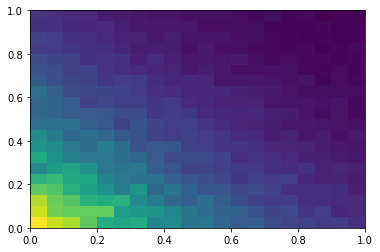

In [33]:
# test Metropolis
a = 2
p = lambda x: a**2/(1-np.exp(-a))**2 * np.exp(-a*x[0]-a*x[1])
metropolis = Metropolis(p, initial=np.array([.5, .5]), next_candidate=lambda s: np.random.rand(2))
rand = np.array([metropolis() for i in range(100000)]).transpose()
_= plt.hist2d(rand[0], rand[1], bins=20, normed=True)

MC Plain	average (deviation * sqrt(N)): 0.2153077689555903, average (error * sqrt(N)): 0.35399895256000635
MC Importance	average (deviation * sqrt(N)): 0.019880081091772576, average (error * sqrt(N)): 0.0309492532925843


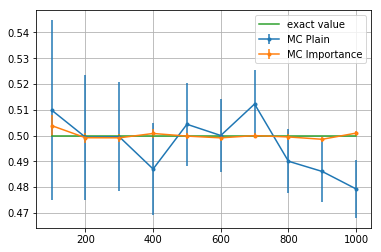

In [34]:
# Now apply distributions to importance sampling

# sin^2
f = lambda x: np.sin(x*2*np.pi)**2

p_ideal = lambda x: f(x+.005) / (1/2) # almost ideal
sampling = AcceptionRejection(p_ideal, 2) # max value of f is 1

compare_integration(f, 1/2, Nmin=100, Nmax=1000, Nstep=100, 
                    methods=[MonteCarloPlain(), MonteCarloImportance(sampling_fn=sampling, pdf=p_ideal)])

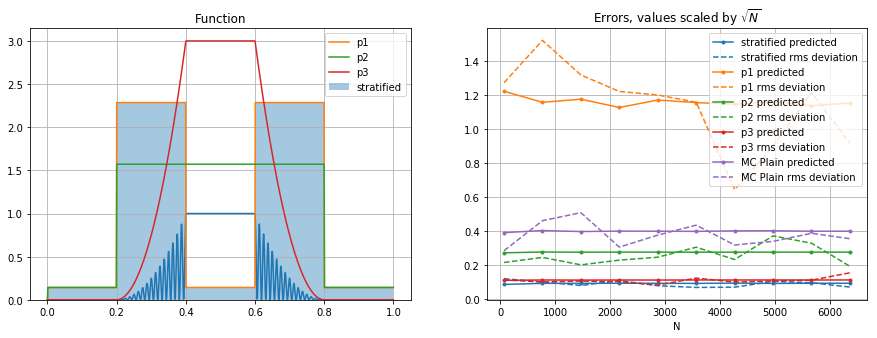

In [41]:
# use test_function and true_value from earlier

# compare importance sampling to the stratified boxing from before
vol = CubeVolumes(5, otherNs=2, Ns={(1,):32, (3,):32})
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/vol.totalN/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/vol.totalN/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptionRejection(p1, 3)
sampling2 = AcceptionRejection(p2, 2)
sampling3 = AcceptionRejection(p3, 3.5)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

plt.plot(x,p1(x), label="p1")
plt.plot(x,p2(x), label="p2")
plt.plot(x,p3(x), label="p3")
plot_1d_volume(vol, "stratified")
plt.legend()

plt.subplot(122)
compare_errors(test_function, test_function_true_value, iterations=10, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
               methods=[MonteCarloStratified(volumes=vol, name="stratified"),
                        MonteCarloImportance(sampling_fn=sampling1, pdf=p1, name="p1"),
                        MonteCarloImportance(sampling_fn=sampling2, pdf=p2, name="p2"),
                        MonteCarloImportance(sampling_fn=sampling3, pdf=p3, name="p3"),
                        MonteCarloPlain()])
plt.show()

## Adaptive Methods
### VEGAS Monte Carlo

In [42]:
def damped_update(old, new, c, j):
    return new * (c)/(j+1+c) + (j+1)/(j+1+c) * old

In [43]:
# VEGAS
class MonteCarloVEGAS(object):
    def __init__(self, Nj=100, dim=1, divisions=1, c=3, name="MC VEGAS"):
        """
        c: each iteration, the bin sizes are a combination of old and new bin sizes.
            the weight of the old bin sizes increases with the number of iterations.
            c gives the iteration where both have equal weight (=1 -> equal in first iteration).
            therefore: larger c means the bins change more, smaller means the bins tend to stay close to uniform.
        """
        self.dim = dim
        self.sizes = np.ones((dim, divisions))/divisions  # the configuration is defined by the sizes of the bins
        self.Nj = Nj  # number of samples per iteration
        self.divisions = divisions  # number of bins along each axis
        self.c = c  # measure of damping (smaller means more damping)
        self.method_name = name
        
    def choice(self):
        """ Return a random choice ob bin, specified by its multi-index. """
        return np.random.randint(0, self.divisions, self.dim)
        
    def random_x(self, bin_index):
        """ Return a random number in the bin of given multi-index. """
        x = np.empty(self.dim)
        for i in range(self.dim):
            x[i] = np.sum(self.sizes[i][:bin_index[i]])
        x += self.sizes[np.arange(self.dim), bin_index] * np.random.rand(self.dim)
        return x
    
    def pdf(self, bin_index):
        """ Give the probability density of finding a point in bin with given index. """
        return 1/np.power(self.divisions, self.dim) / np.prod(self.sizes[np.arange(self.dim), bin_index])
        
    def plot_pdf(self):
        """ Plot the pdf resulting from the current bin sizes. """
        assert self.dim == 1, "Can only plot 1D pdf"
        xs = []
        ys = []
        x = 0
        for i, size in zip(range(self.divisions), self.sizes[0]):
            xs.append(x)
            y = 1/self.divisions/size
            ys.append(y)
            x += size
            xs.append(x)
            ys.append(y)
        plt.plot(xs, ys, label="VEGAS pdf")
        
    def __call__(self, f, N, apriori=True, xhi=False):
        if apriori:
            # start anew
            self.sizes = np.ones((self.dim, self.divisions))/self.divisions
            
        assert N >= self.Nj, "N must be at least Nj (default 100) initially set."
        
        Nj = self.Nj
        m = N // Nj       # number of iterations (the true N is smaller or equal the passed N parameter!)
        Ej = np.zeros(m)  # The estimate in each iteration j
        Sj = np.zeros(m)  # sample variance in each iteration j, estimating the variance of Ej

        for j in range(m):
            Ei = np.zeros((self.dim, self.divisions))
            Ni = np.zeros((self.dim, self.divisions))  # keep track of number of samples in each "projected" bin
            for i in range(Nj):
                bin_index = self.choice()
                x = self.random_x(bin_index)
                f_sample = f(x) / self.pdf(bin_index)
                Ej[j] +=  f_sample / Nj
                Sj[j] += (f_sample)**2 / Nj
                # in each dimension add the contribution to the given bin index (so in total add in self.dim places)
                Ei[np.arange(self.dim), bin_index] += f_sample / Nj
                
            # new size = 1/(old value * (getting larger with j) + best guess new * (getting smaller with j))
            self.sizes = 1/damped_update(Ej[j]/self.sizes, self.divisions * Ei, self.c, j)
            self.sizes = self.sizes / np.add.reduce(self.sizes, axis=1)[:, np.newaxis] # normalize
            
        Sj -= Ej**2             # at this point Sj is the sample variance of f/pdf
        Sj = Sj / Nj            # this completes the computation of Sj (estimated variance of Ej)
        
        C = np.sum(Nj/Sj)       # normalization factor
        E = np.sum(Nj*Ej/Sj)/C  # final estimate of e: weight by Nj and Sj (note: could generalize to make Nj vary with j)
        if xhi:
            # xhi^2/dof, have m values that are combined so here dof = m - 1
            xhi2 = np.sum((Ej - E)**2/Sj)/(m-1)
            return E, np.sqrt(np.sum(Nj**2/Sj)/C**2), xhi2
        else:
            return E, np.sqrt(np.sum(Nj**2/Sj)/C**2)

In [44]:
# see if the equation for error estimate is reasonable
trueval = .25
f = lambda x: x[0]*x[1]
ms = 0
var_mean = 0
N = 1000
for i in range(N):
    vegas = MonteCarloVEGAS(dim=2, divisions=10)
    E, var = vegas(f, 100)
    ms += (E - trueval)**2 / N
    var_mean += var/N
print(np.sqrt(ms), var_mean)

0.02155651423744236 0.021947554347268344


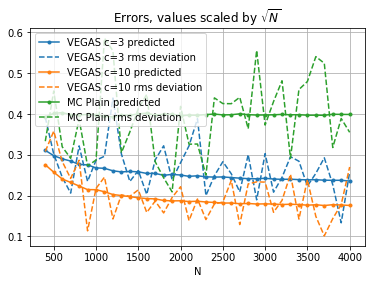

In [45]:
vegas3 = MonteCarloVEGAS(divisions=10, Nj=100, c=3, name="VEGAS c=3")
vegas5 = MonteCarloVEGAS(divisions=10, Nj=100, c=10, name="VEGAS c=10")
compare_errors(test_function, test_function_true_value, iterations=10, Nmin=400, Nmax=4000, Nstep=100,
               methods=[vegas3, vegas5, MonteCarloPlain()])

(0.2670369769683439, 0.0006050871824531221, 1.2148273766628872)


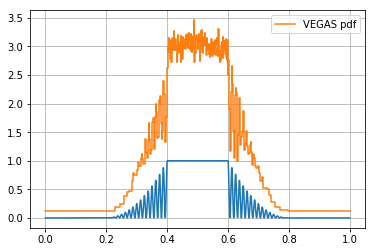

In [46]:
vegas = MonteCarloVEGAS(divisions=300, Nj=1000, c=400)
print(vegas(test_function, 50000, xhi=True))

x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
vegas.plot_pdf()
plt.legend()
plt.grid()

## Multi Channel Monte Carlo

In [47]:
class Channel(object):
    def __init__(self, sampling_fn, pdf):
        self.sampling_fn = sampling_fn
        self.pdf = pdf
        
    def __call__(self):
        return self.sampling_fn()
        
class UniformChannel(Channel):
    def __init__(self, dim=1, xmin=0, xmax=1):
        sampling_fn = lambda: xmin + np.random.rand(dim) * (xmax-xmin)
        super().__init__(sampling_fn, 1/np.prod(xmin-xmax))

class MetropolisChannel(Channel):
    def __init__(self, pdf, dim=1):
        next_canidate = np.random.rand if dim==1 else lambda: np.random.rand(dim)
        sampling_fn = Metropolis(pdf, next_candidate=next_canidate)
        super().__init__(sampling_fn, pdf)

In [48]:
class MonteCarloMultiImportance(object):
    def __init__(self, channels, cweights=None, Nj=100, r1=.2, r2=None, r3=None, name="MC Imp. Mult.", b=.5):
        """ 
        
        N total function evaluations are spread into potentially three phases:
        1. Update weights but discrad the integral estimates
        2. Update weights and use values for integral estimation
        3. Don't update weights anymore
        
        Nj gives the number of function evaluations in each iteration in each phase
        r1 gives the ratio of iterations spent in the first phase
        r2 ration of second phase (by default 1-r1-r3)
        r3 ratio of third phase (by default 0)
        
        b: exponent between 1/2 and 1/4, used in updating the weights. """
        self.method_name = name
        self.channels = channels
        self.cweights = np.array(cweights) if cweights is not None else np.ones(len(channels))/len(channels)
        self.apriori_weights = self.cweights
        self.channel_count = len(self.cweights)
        self.b = b
        assert len(self.channels) == self.channel_count, "each channel needs assigned a channel weight"
        assert np.isclose(np.sum(self.cweights), 1), "channel weights must sum to 1"
        
        self.Nj = Nj
        self.r1 = r1
        self.r3 = r3 if r3 is not None else 0
        self.r2 = 1 - self.r1 - self.r3
        assert self.r1 >= 0 and self.r2 >= 0 and self.r3 >= 0, "Ratios cannot be smaller than 0"
        assert self.r1 + self.r2 + self.r3 == 1, "Ratios must sum to 1"
    
    def pdf(self, x):
        p = 0
        for i in range(self.channel_count):
            p += self.cweights[i] * self.channels[i].pdf(x)
        return p
    
    def plot_pdf(self):
        x = np.linspace(0, 1, 1000)
        y = [self.pdf(xi) for xi in x]
        plt.plot(x, y, label="total pdf")
        
    def iterate(self, f, N, update_weights=True, compute_estimate=True):
        """ Returns estimate and sample variance(!) of estimate. """
        E = 0  # integral estimate 
        S = 0  # variance (usually denoted S^2 for sample variance)
        Wi = np.zeros(self.channel_count)        # variance of (f/pdf) in each of the channels
        Ni = (self.cweights * N).astype(np.int)  # not sure if this kind of assuming Ni = weight * N is statistically problematic
        non_zero_channels = np.where(self.cweights > 0)[0]
        for n in range(N-np.sum(Ni)):
            c = np.random.choice(non_zero_channels)
            Ni[c] += 1
        
        for channel, c in zip(self.channels, range(self.channel_count)):
            for i in range(Ni[c]):
                x = self.channels[c]()
                f_sample = f(x)/self.pdf(x)
                if compute_estimate:
                    E += f_sample / N
                Wi[c] += (f_sample)**2 / Ni[c]
        if update_weights:
            factors = self.cweights * np.power(Wi, self.b)
            self.cweights = factors / np.sum(factors)
        if compute_estimate:
            S = (np.sum(self.cweights * Wi) - E**2) / N
        return E, S
        
    def __call__(self, f, N, apriori=True):
        if apriori:
            self.cweights = self.apriori_weights  # start over
        
        num_iterations = N // self.Nj
        m1 = int(self.r1 * num_iterations)
        m2 = int(self.r2 * num_iterations)
        m3 = int(self.r3 * num_iterations)
        N_remaining = N - (m1 + m2 + m3) * num_iterations
        
        weighted_sum = 0
        total_var = 0
        normalization = 0
       
        for m in range(m1):
            self.iterate(f, num_iterations, update_weights=True, compute_estimate=False)
        
        for m in range(m2):
            est, var = self.iterate(f, self.Nj, update_weights=True, compute_estimate=True)
            weighted_sum += num_iterations * est / var  # can generelize algorithm such that num_iterations varies (if desired)
            total_var += num_iterations**2 / var
            normalization += num_iterations / var
              
        for m in range(m3):
            est, var = self.iterate(f, self.Nj, update_weights=False, compute_estimate=True)
            weighted_sum += num_iterations * est / var
            total_var += num_iterations**2 / var
            normalization += num_iterations / var
        
        if N_remaining > 0:
            est, var = self.iterate(f, N_remaining, update_weights=False, compute_estimate=True)
            weighted_sum += num_iterations * est / var
            total_var += num_iterations**2 / var
            normalization += num_iterations / var
            
        return weighted_sum / normalization, np.sqrt(total_var / normalization**2)

rms vs mean error
0.00903593493555824 0.009258213744735578


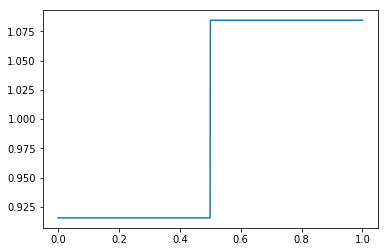

In [49]:
f = lambda x: test_function(x)
true_val = test_function_true_value
c0 = Channel(np.random.rand, lambda x: 1)
c1 = Channel(lambda: np.random.rand()/2, lambda x: 2*(x<=.5))
c2 = Channel(lambda: .5+np.random.rand()/2, lambda x: 2*(x>.5))
mcmci = MonteCarloMultiImportance([c0, c1, c2], r1=0, r3=0, Nj=100)

ms = 0
err_mean = 0
N = 100
for i in range(N):
    E, err = mcmci(f, 1000)
    ms += (E - true_val)**2 / N
    err_mean += err/N
print("rms vs mean error")
print(np.sqrt(ms), err_mean)
mcmci.plot_pdf()

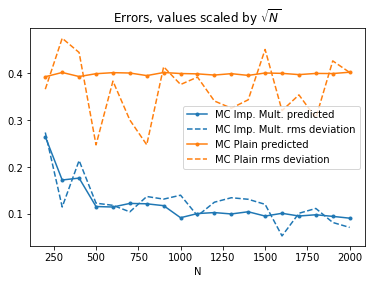

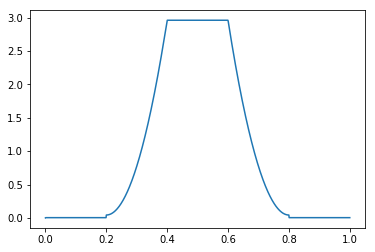

In [83]:
# use on test_function with the three probability distributions from before
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/70/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/70/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptionRejection(p1, 3)
sampling2 = AcceptionRejection(p2, 2)
sampling3 = AcceptionRejection(p3, 3.5)
c1 = Channel(sampling1, p1)
c2 = Channel(sampling2, p2)
c3 = Channel(sampling3, p3)

mcmci = MonteCarloMultiImportance([c1, c2, c3], Nj=100, r3 = .4)
compare_errors(test_function, test_function_true_value, Nmin=200, Nmax=2000, Nstep=100, iterations=10, 
               methods=[mcmci, MonteCarloPlain()])
plt.show()
mcmci.plot_pdf()
plt.show()

0.0014821786901581535 0.005494840262539819


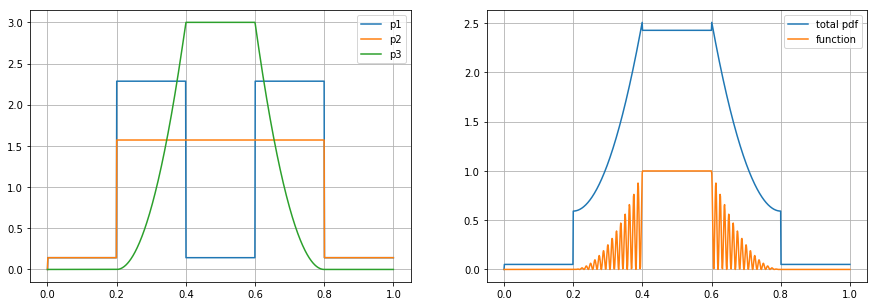

array([0.04317999, 0.31420212, 0.64261789])

In [101]:
mcmci = MonteCarloMultiImportance([c1, c2, c3], Nj=100, r3=.4)

plt.figure(figsize=(15,5))
plt.subplot(121)
x = np.linspace(0,1,1000)
plt.plot(x, p1(x), label="p1")
plt.plot(x, p2(x), label="p2")
plt.plot(x, p3(x), label="p3")
plt.grid()
plt.legend()

plt.subplot(122)
est, err = mcmci(test_function, 600)
print(est-test_function_true_value, err)
mcmci.plot_pdf()
plt.plot(x,test_function(x), label="function")
plt.legend()
plt.grid()

plt.show()
mcmci.cweights